## Game Review Analysis and Sentiment Scoring

### Load all relevant libraries

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import torch
import re
import emoji
from bs4 import BeautifulSoup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

### Exploratory Data Analysis

In [103]:
plt.style.use('ggplot')

In [104]:
df_review = pd.read_csv('GameReviews_consolidated.csv')
df_stat = pd.read_csv('GameStats_consolidated.csv')

In [105]:
df_review.head()

,Unnamed: 0,Unnamed: 0.1,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,appid,timestamp_dev_responded,developer_response
0,0,1283580_1,76352783,76561198044593213,english,wooow awesome game! had a lot of fun. It is ha...,1600726883,1600726883,True,20,0,0.695501,0,True,False,False,1283580,NaN,NaN
1,1,1283580_2,70557090,76561198088813295,english,"A simple, addictive and challenging game. When...",1591740908,1591740908,True,12,0,0.676471,0,True,False,False,1283580,NaN,NaN
2,2,1283580_3,76356193,76561197993312336,english,This game took me back to the old days of arca...,1600733890,1600733890,True,18,0,0.491638,0,True,False,False,1283580,NaN,NaN
3,3,1283580_4,76358855,76561198319721830,english,It's a good game for a good price. It made me ...,1600739253,1600739253,True,10,0,0.491387,0,True,False,False,1283580,NaN,NaN
4,4,1283580_5,70843366,76561198070981262,english,Plays great in Linux on the Latest PROTON! Als...,1592252895,1592252895,True,0,0,0.456160,0,True,False,False,1283580,NaN,NaN


In [106]:
df_review = df_review.rename(columns={'Unnamed: 0.1': 'reviewid'})
df_review.head()

,Unnamed: 0,reviewid,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,appid,timestamp_dev_responded,developer_response
0,0,1283580_1,76352783,76561198044593213,english,wooow awesome game! had a lot of fun. It is ha...,1600726883,1600726883,True,20,0,0.695501,0,True,False,False,1283580,NaN,NaN
1,1,1283580_2,70557090,76561198088813295,english,"A simple, addictive and challenging game. When...",1591740908,1591740908,True,12,0,0.676471,0,True,False,False,1283580,NaN,NaN
2,2,1283580_3,76356193,76561197993312336,english,This game took me back to the old days of arca...,1600733890,1600733890,True,18,0,0.491638,0,True,False,False,1283580,NaN,NaN
3,3,1283580_4,76358855,76561198319721830,english,It's a good game for a good price. It made me ...,1600739253,1600739253,True,10,0,0.491387,0,True,False,False,1283580,NaN,NaN
4,4,1283580_5,70843366,76561198070981262,english,Plays great in Linux on the Latest PROTON! Als...,1592252895,1592252895,True,0,0,0.456160,0,True,False,False,1283580,NaN,NaN


In [107]:
df_stat.head()

,Unnamed: 0,Unnamed: 0.1,appid,name,developer,publisher,score_rank,positive,negative,userscore,...,ccu,languages,genre,tags,num_reviews,review_score,review_score_desc,total_positive,total_negative,total_reviews
0,0,0,250340,Blockland,"Eric Hartman, Ben Garney, Anthony Rotondo",Step 1 Games LLC,NaN,4042,1499,0,...,46,English,"Action, Indie, Simulation","Sandbox, Building, Multiplayer, LEGO, Open Wor...",4,6,Mostly Positive,1678,676,2354
1,1,1,429570,The Walking Dead: Michonne - A Telltale Minise...,Telltale Games,Skybound Games,NaN,4754,1292,0,...,9,"English, French, German, Spanish - Spain, Port...",Adventure,"Adventure, Zombies, Story Rich, Choices Matter...",1,6,Mostly Positive,1407,467,1874
2,2,2,775500,SCARLET NEXUS,BANDAI NAMCO Studios Inc.,BANDAI NAMCO Entertainment,NaN,8666,1523,0,...,367,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2892,346,3238
3,3,3,272470,The Incredible Adventures of Van Helsing II,NeocoreGames,NeocoreGames,NaN,1581,725,0,...,7,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, Indie, RPG","RPG, Action, Adventure, Hack and Slash, Action...",20,5,Mixed,479,237,716
4,4,4,222750,Wargame: Airland Battle,Eugen Systems,Eugen Systems,NaN,3670,505,0,...,47,"English, German, French, Italian, Spanish - Sp...","Indie, Simulation, Strategy","Strategy, RTS, Military, Cold War, Wargame, Re...",1,8,Very Positive,1921,276,2197


In [108]:
#Checking for duplicates and remove columns 
df_review = df_review.drop(columns = ['Unnamed: 0'])
df_review = df_review.drop_duplicates()

#Removing empty review columns
df_review = df_review.dropna(subset=['review'])

df_stat = df_stat.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])
df_stat = df_stat.drop_duplicates()

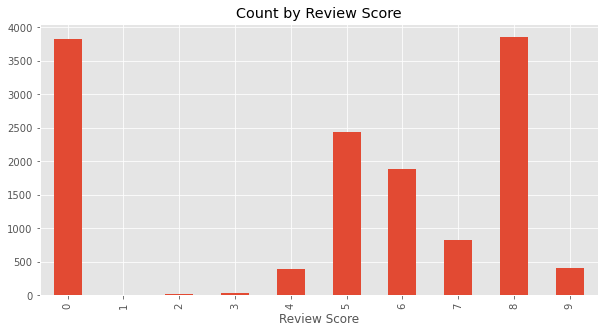

In [109]:
ax = df_stat['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count by Review Score',
          figsize=(10, 5))
ax.set_xlabel('Review Score')
plt.show()

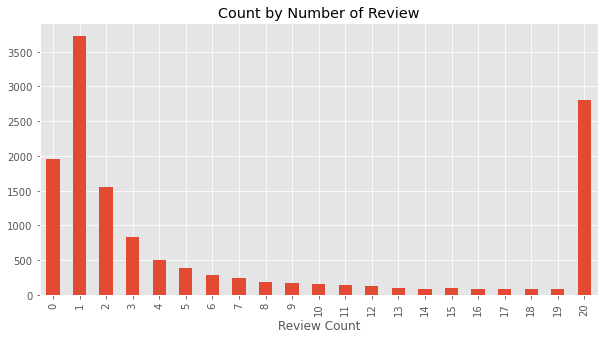

In [110]:
ax = df_stat['num_reviews'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count by Number of Review',
          figsize=(10, 5))
ax.set_xlabel('Review Count')
plt.show()

#### Review Data Preprocessing

In [114]:
#Function to replace emoticons with a meanigful english word (https://en.wikipedia.org/wiki/List_of_emoticons)
def get_dict_emoticons():
    
    return {
        ":‑)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }

#Function to expand the contractions(https://en.wikipedia.org/wiki/Contraction_%28grammar%29)
def get_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "gotcha" : "got it",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }

#Function to pre-process reviews data before performing sentiment analysis
def preprocess_reviews():
    #iterate over each row and clean up reviews data to prpeare for Sentiment Scoring
    for i, row in tqdm(df_review.iterrows(), total=reviewCount):
        review = row['review']
        
        #Remove any address piece as they are not useful for sentiment scoring
        review = ' '.join(re.sub("(\w+:\/\/\S+)", " ", review).split())
        
        ##Remove HTMl tags from the review, if any
        review = BeautifulSoup(review).get_text()
   

        #Remove all hashtags ands mentions from the reviews
        review = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", review).split())

        #Remove Punctuation from the review
        review = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", review).split())

        #Convert the reviews to lower case
        review = review.lower()

        #Remove contractions and inflate the word
        dict_contractions = get_dict_contractions()
        review = review.replace("’","'")
        words = review.split()
        reformed = [dict_contractions[word] if word in dict_contractions else word for word in words]
        review = " ".join(reformed)

       
        #Replace Emoticons with meaningful text for sentiment scoring
        dict_emoticons = get_dict_emoticons()  
        words = review.split()
        reformed = [dict_emoticons[word] if word in dict_emoticons else word for word in words]
        review = " ".join(reformed)

        #Replace emoji's with meaningful english text
        review = emoji.demojize(review)
        review = review.replace(":"," ")
        review = ' '.join(review.split())
        
        #Update review in data frame 
        row['review'] = review


In [115]:
preprocess_reviews()

  0%|          | 0/90132 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:337: MarkupResemblesLocatorWarning: "/" looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:346: MarkupResemblesLocatorWarning: "Con: Its REALLY short. It has TWO levels. Count them: not one, not two, but... no wait... yes two. Pro: The game is quite a comfortable VR experience. Con: Achievement didn't work for me. Pro: Only 5 bucks." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


### Model Selection

#### Implement VADER Scoring

In [116]:
#Use this command to download VADER
#nltk.download('vader_lexicon')

In [141]:
#Create instance of SentimentIntensityAnalyzer
sentAnlzer = SentimentIntensityAnalyzer()

#Calculate the Polarity Score for the entire dataset
dict_polarity = {}

#Store the exceptions while analysing sentiment polarity
dict_errors = {}

#Counter to identify errors
counter = 0
reviewCount = len(df_review)

for i, row in tqdm(df_review.iterrows(), total=reviewCount):
    try:
        dict_polarity[row['reviewid']] = sentAnlzer.polarity_scores(row['review'])
    except Exception as e:
        counter += 1
        dict_errors[row['reviewid']] = str(e)
    
print(f" Total Reviews : {reviewCount}\n Successfully Analyzed : {reviewCount - counter}\n ") 
if counter >0 :
    print(f" Failed to Analyze: {counter}")

  0%|          | 0/90132 [00:00<?, ?it/s]

 Total Reviews : 90132
 Successfully Analyzed : 90132
 


In [237]:
df_vad_polarity = pd.DataFrame(dict_polarity).T
df_vad_polarity = df_vad_polarity.reset_index().rename(columns={'index': 'reviewid'})
df_vad_polarity.rename(columns = {'neg':'vader_neg', 'neu':'vader_neu', 'pos': 'vader_pos', 'compound' : 'vader_compound'}, inplace = True)
df_GameReviews = df_vad_polarity.merge(df_review, how='left', on = 'reviewid')
df_vad_polarity.head()

,reviewid,vader_neg,vader_neu,vader_pos,vader_compound
0,1283580_1,0.076,0.590,0.334,0.8805
1,1283580_2,0.000,0.822,0.178,0.6103
2,1283580_3,0.000,0.571,0.429,0.9626
3,1283580_4,0.000,0.693,0.307,0.8774
4,1283580_5,0.000,0.791,0.209,0.8772


In [205]:
#Create an empty dataframe
df_Polarity = pd.DataFrame(columns = ['appid', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'])

#Loop through stats 
for i, row in tqdm(df_stat.iterrows(), total=len(df_stat)):
    df = df_vad_polarity[df_vad_polarity['reviewid'].str.contains(str(row['appid']) + '_')]
    df_len = len(df)
    if(df_len >0): 
        df = df.sum(axis = 0)
        neg = round(df[1]/df_len,3)
        neu = round(df[2]/df_len,3)
        pos = round(df[3]/df_len,3)
        compound = round(df[4]/df_len,3)
        #score = calculateScore(neg,neu, pos, compound )
    #else:
        #score = 'NA'
        #neg = 0
        #neu = 0
        #pos = 0
        #compund = 0
    df_Polarity = df_Polarity.append({'appid' : str(row['appid']), 'vader_neg' : neg, 'vader_neu' : neu, 'vader_pos' : pos,'vader_compound' : compound}, ignore_index = True)
    #break

  0%|          | 0/13705 [00:00<?, ?it/s]

In [232]:
#Merge the 2 data frames into a single frame and validate
df_stat['appid'] = df_stat['appid'].astype(str)
df_GameStats = df_Polarity.merge(df_stat, how='left', on = 'appid')


In [234]:
df_GameStats.head()

,appid,vader_neg,vader_neu,vader_pos,vader_compound,name,developer,publisher,score_rank,positive,...,ccu,languages,genre,tags,num_reviews,review_score,review_score_desc,total_positive,total_negative,total_reviews
0,250340,0.072,0.698,0.230,0.274,Blockland,"Eric Hartman, Ben Garney, Anthony Rotondo",Step 1 Games LLC,NaN,4042,...,46,English,"Action, Indie, Simulation","Sandbox, Building, Multiplayer, LEGO, Open Wor...",4,6,Mostly Positive,1678,676,2354
1,429570,0.132,0.688,0.180,0.370,The Walking Dead: Michonne - A Telltale Minise...,Telltale Games,Skybound Games,NaN,4754,...,9,"English, French, German, Spanish - Spain, Port...",Adventure,"Adventure, Zombies, Story Rich, Choices Matter...",1,6,Mostly Positive,1407,467,1874
2,775500,0.096,0.628,0.276,0.446,SCARLET NEXUS,BANDAI NAMCO Studios Inc.,BANDAI NAMCO Entertainment,NaN,8666,...,367,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2892,346,3238
3,775500,0.096,0.628,0.276,0.446,SCARLET NEXUS,BANDAI NAMCO Studios Inc.,BANDAI NAMCO Entertainment,NaN,8666,...,367,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2891,346,3237
4,272470,0.091,0.741,0.169,0.429,The Incredible Adventures of Van Helsing II,NeocoreGames,NeocoreGames,NaN,1581,...,7,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, Indie, RPG","RPG, Action, Adventure, Hack and Slash, Action...",20,5,Mixed,479,237,716


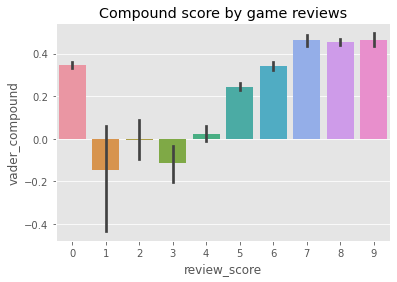

In [216]:
ax = sns.barplot(data = df_GameStats , x = 'review_score', y = 'vader_compound')
ax.set_title('Compound score by game reviews')
plt.show()

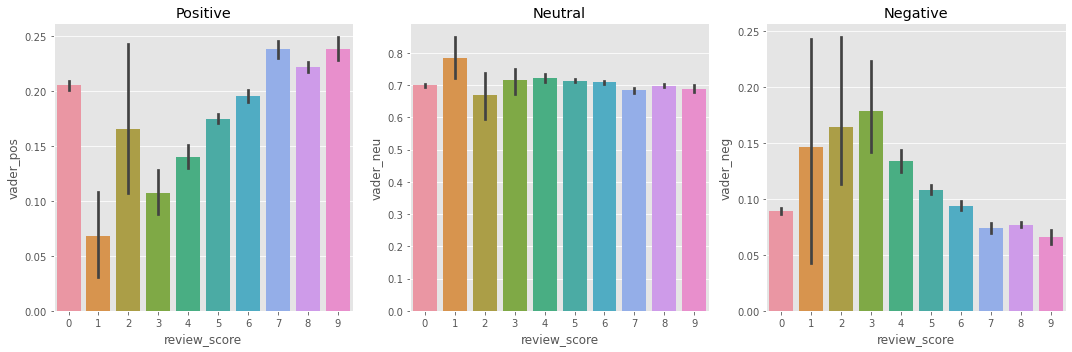

In [217]:
fig,axis = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data = df_GameStats, x = 'review_score', y = 'vader_pos', ax= axis[0] )
sns.barplot(data = df_GameStats, x = 'review_score', y = 'vader_neu', ax= axis[1] )
sns.barplot(data = df_GameStats, x = 'review_score', y = 'vader_neg', ax= axis[2] )
axis[0].set_title('Positive')
axis[1].set_title('Neutral')
axis[2].set_title('Negative')
plt.tight_layout()
plt.show()

#### Roberta Model from Transformers

In [133]:
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [134]:
def roberta_score(comment):
    tokenized_text = tokenizer(comment, return_tensors = 'pt')
    output = model(**tokenized_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    dict_scores = {'roberta_pos' : scores[2], 'robert_neu' : scores[1], 'roberta_neg': scores[0]}
    return dict_scores

In [137]:
#Store Polarity score for reoberta in dictionary
dict_roberta = {}

#Reset counter and error dictionary
counter = 0
dict_errors.clear()

#Loop through reviews to calculate sentiment with roberta
for i, row in tqdm(df_review.iterrows(), total=reviewCount):
    try:
        dict_roberta[row['reviewid']] = roberta_score(row['review'])
    except Exception as e:
        counter += 1
        dict_errors[row['reviewid']] = str(e)
    
print(f" Total Reviews : {reviewCount}\n Successfully Analyzed : {reviewCount - counter}\n ") 
if counter >0 :
    print(f"Failed to Analyze: {counter}")

  0%|          | 0/90132 [00:00<?, ?it/s]

 Total Reviews : 90132
 Successfully Analyzed : 83680
 
 Failed to Analyze: 6452


In [239]:
df_rob_polarity = pd.DataFrame(dict_roberta).T
df_rob_polarity = df_rob_polarity.reset_index().rename(columns={'index': 'reviewid'})
df_rob_polarity.rename(columns = {'neg':'roberta_neg', 'neu':'roberta_neu', 'pos': 'roberta_pos'}, inplace = True)
df_GameReviews = df_rob_polarity.merge(df_GameReviews, how='left', on = 'reviewid')
df_rob_polarity.head()

,reviewid,roberta_pos,robert_neu,roberta_neg
0,1283580_1,0.986401,0.009664,0.003935
1,1283580_2,0.943884,0.053277,0.002839
2,1283580_3,0.990329,0.008281,0.001390
3,1283580_4,0.979614,0.016933,0.003453
4,1283580_5,0.811392,0.141342,0.047266


In [242]:
df_GameReviews.head()

,reviewid,roberta_pos,robert_neu,roberta_neg,vader_neg,vader_neu,vader_pos,vader_compound,recommendationid,author,...,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,appid,timestamp_dev_responded,developer_response
0,1283580_1,0.986401,0.009664,0.003935,0.076,0.590,0.334,0.8805,76352783,76561198044593213,...,20,0,0.695501,0,True,False,False,1283580,NaN,NaN
1,1283580_2,0.943884,0.053277,0.002839,0.000,0.822,0.178,0.6103,70557090,76561198088813295,...,12,0,0.676471,0,True,False,False,1283580,NaN,NaN
2,1283580_3,0.990329,0.008281,0.001390,0.000,0.571,0.429,0.9626,76356193,76561197993312336,...,18,0,0.491638,0,True,False,False,1283580,NaN,NaN
3,1283580_4,0.979614,0.016933,0.003453,0.000,0.693,0.307,0.8774,76358855,76561198319721830,...,10,0,0.491387,0,True,False,False,1283580,NaN,NaN
4,1283580_5,0.811392,0.141342,0.047266,0.000,0.791,0.209,0.8772,70843366,76561198070981262,...,0,0,0.456160,0,True,False,False,1283580,NaN,NaN


In [243]:
#Create an empty dataframe
df_Polarity = pd.DataFrame(columns = ['appid', 'roberta_neg', 'roberta_neu', 'roberta_pos'])

#Loop through stats 
for i, row in tqdm(df_stat.iterrows(), total=len(df_stat)):
    df = df_rob_polarity[df_rob_polarity['reviewid'].str.contains(str(row['appid']))]
    df_len = len(df)
    if(df_len >0): 
        df = df.sum(axis = 0)
        neg = round(df[3]/df_len,3)
        neu = round(df[2]/df_len,3)
        pos = round(df[1]/df_len,3)
    #else:
        #neg = 0
        #neu = 0
        #pos = 0
    df_Polarity = df_Polarity.append({'appid' : str(row['appid']), 'roberta_neg' : neg, 'roberta_neu' : neu, 'roberta_pos' : pos}, ignore_index = True)
    

  0%|          | 0/13705 [00:00<?, ?it/s]

In [244]:
#Merge the data frame into a single frame and validate
df_GameStats = df_Polarity.merge(df_GameStats, how='left', on = 'appid')
df_GameStats.head()

,appid,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,name,developer,...,ccu,languages,genre,tags,num_reviews,review_score,review_score_desc,total_positive,total_negative,total_reviews
0,250340,0.387,0.357,0.256,0.072,0.698,0.230,0.274,Blockland,"Eric Hartman, Ben Garney, Anthony Rotondo",...,46,English,"Action, Indie, Simulation","Sandbox, Building, Multiplayer, LEGO, Open Wor...",4,6,Mostly Positive,1678,676,2354
1,429570,0.148,0.246,0.606,0.132,0.688,0.180,0.370,The Walking Dead: Michonne - A Telltale Minise...,Telltale Games,...,9,"English, French, German, Spanish - Spain, Port...",Adventure,"Adventure, Zombies, Story Rich, Choices Matter...",1,6,Mostly Positive,1407,467,1874
2,775500,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,BANDAI NAMCO Studios Inc.,...,367,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2892,346,3238
3,775500,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,BANDAI NAMCO Studios Inc.,...,367,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2891,346,3237
4,775500,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,BANDAI NAMCO Studios Inc.,...,367,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2892,346,3238


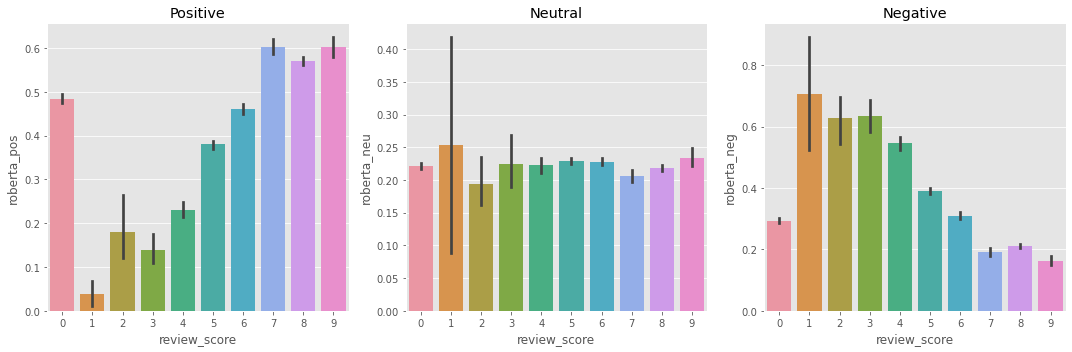

In [158]:
fig,axis = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data = df_GameStats, x = 'review_score', y = 'roberta_pos', ax= axis[0] )
sns.barplot(data = df_GameStats, x = 'review_score', y = 'roberta_neu', ax= axis[1] )
sns.barplot(data = df_GameStats, x = 'review_score', y = 'roberta_neg', ax= axis[2] )
axis[0].set_title('Positive')
axis[1].set_title('Neutral')
axis[2].set_title('Negative')
plt.tight_layout()
plt.show()

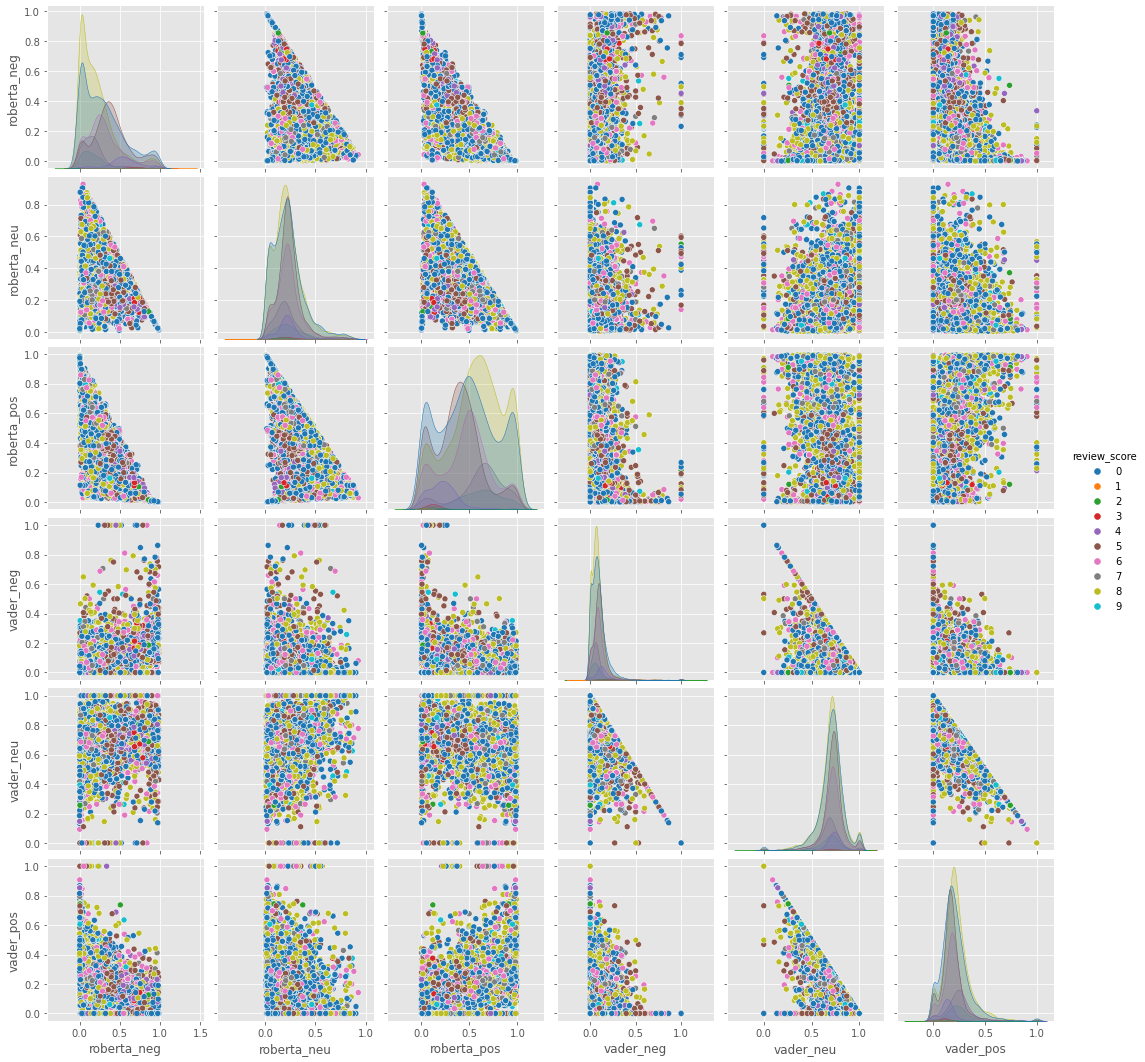

In [161]:
sns.pairplot(data = df_GameStats, vars=['roberta_neg', 'roberta_neu', 'roberta_pos', 'vader_neg',
       'vader_neu', 'vader_pos'], hue= 'review_score', palette = 'tab10')
plt.show()

#### BERT Model from Transformers

In [162]:
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

In [171]:
def sentiment_bert(review):
    tokens = tokenizer.encode(review, return_tensors = 'pt')
    result = model(tokens)
    return int(torch.argmax(result.logits)) + 1

In [179]:
#Dictionary to score bert scores
dict_bert = {}

#Reset counters
counter = 0
dict_errors.clear()

reviewCount = len(df_GameReviews)

#Loop through the dataframe to get the sentiment score
for i, row in tqdm(df_GameReviews.iterrows(), total=reviewCount):
    try:
        dict_bert[row['reviewid']] = sentiment_bert(row['review'][:512])        
    except Exception as e:
        counter += 1
        dict_errors[row['reviewid']] = str(e)
            
print(f"Total Reviews : {reviewCount}\n Successfully Analyzed : {reviewCount - counter}\n ") 
if counter >0 :
    print(f"Failed to Analyze: {counter}")    

  0%|          | 0/83680 [00:00<?, ?it/s]

Total Reviews : 83680
 Successfully Analyzed : 83680
 


In [245]:
df_bert_polarity = pd.DataFrame(columns=['reviewid', 'bert_score'])
df_bert_polarity['reviewid'] = list(dict_bert.keys())
df_bert_polarity['bert_score'] = list(dict_bert.values())
df_GameReviews = df_GameReviews.merge(df_bert_polarity, how='left', on = 'reviewid')
df_bert_polarity.head()

,reviewid,bert_score
0,1283580_1,5
1,1283580_2,4
2,1283580_3,5
3,1283580_4,4
4,1283580_5,4


In [246]:
df_GameReviews.head()

,reviewid,roberta_pos,robert_neu,roberta_neg,vader_neg,vader_neu,vader_pos,vader_compound,recommendationid,author,...,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,appid,timestamp_dev_responded,developer_response,bert_score
0,1283580_1,0.986401,0.009664,0.003935,0.076,0.590,0.334,0.8805,76352783,76561198044593213,...,0,0.695501,0,True,False,False,1283580,NaN,NaN,5
1,1283580_2,0.943884,0.053277,0.002839,0.000,0.822,0.178,0.6103,70557090,76561198088813295,...,0,0.676471,0,True,False,False,1283580,NaN,NaN,4
2,1283580_3,0.990329,0.008281,0.001390,0.000,0.571,0.429,0.9626,76356193,76561197993312336,...,0,0.491638,0,True,False,False,1283580,NaN,NaN,5
3,1283580_4,0.979614,0.016933,0.003453,0.000,0.693,0.307,0.8774,76358855,76561198319721830,...,0,0.491387,0,True,False,False,1283580,NaN,NaN,4
4,1283580_5,0.811392,0.141342,0.047266,0.000,0.791,0.209,0.8772,70843366,76561198070981262,...,0,0.456160,0,True,False,False,1283580,NaN,NaN,4


In [247]:
#Create an empty dataframe
df_Polarity = pd.DataFrame(columns = ['appid', 'bert_score'])

#Loop through stats 
for i, row in tqdm(df_stat.iterrows(), total=len(df_stat)):
    df = df_bert_polarity[df_bert_polarity['reviewid'].str.contains(str(row['appid']))]
    df_len = len(df)
    if(df_len >0): 
        df = df.sum(axis = 0)
        score = round(df[1]/df_len,3)
      
    df_Polarity = df_Polarity.append({'appid' : str(row['appid']), 'bert_score' : score}, ignore_index = True)
    

  0%|          | 0/13705 [00:00<?, ?it/s]

In [248]:
#Merge the data frame into a single frame and validate
df_GameStats = df_Polarity.merge(df_GameStats, how='left', on = 'appid')
len(df_GameStats)

14545

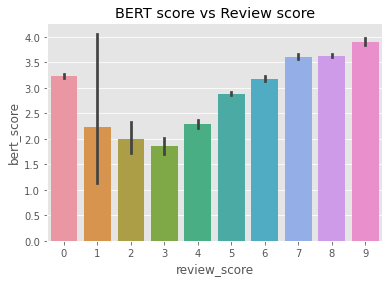

In [249]:
ax = sns.barplot(data = df_GameStats , x = 'review_score', y = 'bert_score')
ax.set_title('BERT score vs Review score')
plt.show()

In [258]:
df_GameReviews[:3][['appid', 'bert_score', 'roberta_neg', 'robert_neu', 'roberta_pos', 'vader_neg', 'vader_neu', 'vader_pos','review']]

,appid,bert_score,roberta_neg,robert_neu,roberta_pos,vader_neg,vader_neu,vader_pos,review
0,1283580,5,0.003935,0.009664,0.986401,0.076,0.590,0.334,wooow awesome game! had a lot of fun. It is ha...
1,1283580,4,0.002839,0.053277,0.943884,0.000,0.822,0.178,"A simple, addictive and challenging game. When..."
2,1283580,5,0.001390,0.008281,0.990329,0.000,0.571,0.429,This game took me back to the old days of arca...


In [259]:
df_GameStats.head()

,appid,bert_score,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,name,...,ccu,languages,genre,tags,num_reviews,review_score,review_score_desc,total_positive,total_negative,total_reviews
0,250340,2.0,0.387,0.357,0.256,0.072,0.698,0.230,0.274,Blockland,...,46,English,"Action, Indie, Simulation","Sandbox, Building, Multiplayer, LEGO, Open Wor...",4,6,Mostly Positive,1678,676,2354
1,429570,4.0,0.148,0.246,0.606,0.132,0.688,0.180,0.370,The Walking Dead: Michonne - A Telltale Minise...,...,9,"English, French, German, Spanish - Spain, Port...",Adventure,"Adventure, Zombies, Story Rich, Choices Matter...",1,6,Mostly Positive,1407,467,1874
2,775500,3.2,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,...,367,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2892,346,3238
3,775500,3.2,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,...,367,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2891,346,3237
4,775500,3.2,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,...,367,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2892,346,3238


In [264]:
df= df_GameReviews[df_GameReviews['appid'] == 250340][['appid', 'bert_score', 'roberta_neg', 'robert_neu', 'roberta_pos', 'vader_neg', 'vader_neu', 'vader_pos','review']]
df['bert'] = df['bert_score']/2
df

,appid,bert_score,roberta_neg,robert_neu,roberta_pos,vader_neg,vader_neu,vader_pos,review,bert
64665,250340,2,0.570796,0.299232,0.129972,0.043,0.803,0.154,"My childhood game, I would play this game almo...",1.0
64666,250340,3,0.021459,0.259694,0.718847,0.000,0.476,0.524,it's ok I guess,1.5
64667,250340,1,0.295306,0.615981,0.088713,0.058,0.821,0.121,"nothing to do in this game, just had to leave ...",0.5
64668,250340,2,0.659286,0.255046,0.085668,0.186,0.692,0.123,its a good game but how to refun this game cuz...,1.0


In [267]:
df_GameStats['review_score_normalized'] = df_GameStats['review_score']/2
df_GameStats.head()

,appid,bert_score,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,name,...,languages,genre,tags,num_reviews,review_score,review_score_desc,total_positive,total_negative,total_reviews,review_score_normalized
0,250340,2.0,0.387,0.357,0.256,0.072,0.698,0.230,0.274,Blockland,...,English,"Action, Indie, Simulation","Sandbox, Building, Multiplayer, LEGO, Open Wor...",4,6,Mostly Positive,1678,676,2354,3.0
1,429570,4.0,0.148,0.246,0.606,0.132,0.688,0.180,0.370,The Walking Dead: Michonne - A Telltale Minise...,...,"English, French, German, Spanish - Spain, Port...",Adventure,"Adventure, Zombies, Story Rich, Choices Matter...",1,6,Mostly Positive,1407,467,1874,3.0
2,775500,3.2,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,...,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2892,346,3238,4.0
3,775500,3.2,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,...,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2891,346,3237,4.0
4,775500,3.2,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,...,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2892,346,3238,4.0


In [282]:
df_Game_Stat = df_GameStats[df_GameStats['num_reviews'] != 0]
df_Game_Stat

,appid,bert_score,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,name,...,languages,genre,tags,num_reviews,review_score,review_score_desc,total_positive,total_negative,total_reviews,review_score_normalized
0,250340,2.000,0.387,0.357,0.256,0.072,0.698,0.230,0.274,Blockland,...,English,"Action, Indie, Simulation","Sandbox, Building, Multiplayer, LEGO, Open Wor...",4,6,Mostly Positive,1678,676,2354,3.0
1,429570,4.000,0.148,0.246,0.606,0.132,0.688,0.180,0.370,The Walking Dead: Michonne - A Telltale Minise...,...,"English, French, German, Spanish - Spain, Port...",Adventure,"Adventure, Zombies, Story Rich, Choices Matter...",1,6,Mostly Positive,1407,467,1874,3.0
2,775500,3.200,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,...,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2892,346,3238,4.0
3,775500,3.200,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,...,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2891,346,3237,4.0
4,775500,3.200,0.229,0.153,0.619,0.096,0.628,0.276,0.446,SCARLET NEXUS,...,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, RPG","Action, Anime, RPG, Adventure, Action RPG, JRP...",20,8,Very Positive,2892,346,3238,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14540,529420,1.000,0.322,0.602,0.076,0.000,1.000,0.000,0.000,Crazy Sapper 3D,...,"English, Russian",Indie,"Indie, Casual, Puzzle, 3D",1,0,3 user reviews,2,1,3,0.0
14541,1579000,4.833,0.003,0.023,0.973,0.043,0.460,0.498,0.782,Super Head Ball,...,English,"Action, Indie","Arena Shooter, Local Multiplayer, 2D Platforme...",6,0,9 user reviews,9,0,9,0.0
14542,373600,3.842,0.152,0.190,0.658,0.163,0.637,0.200,0.315,Weapon of Choice,...,English,"Action, Indie","Action, Indie, Platformer, Aliens, 2D, Retro, ...",20,7,Positive,18,3,21,3.5
14543,1617030,4.556,0.119,0.058,0.824,0.030,0.681,0.290,0.748,tERRORbane,...,"English, Italian, French, German, Simplified C...","Adventure, Indie","Multiple Endings, Adventure, Singleplayer, Cho...",10,6,Mostly Positive,19,6,25,3.0


#### Plots after running the Sentiment analysis using the VADER and transformers models

C:\Users\243074\AppData\Local\Temp\1/ipykernel_16956/958015745.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(df_Game_Stat[:num]['appid'], rotation = 90)
C:\Users\243074\AppData\Local\Temp\1/ipykernel_16956/958015745.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(df_Game_Stat[:num]['appid'], rotation = 90)
C:\Users\243074\AppData\Local\Temp\1/ipykernel_16956/958015745.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(df.index, rotation = 90)


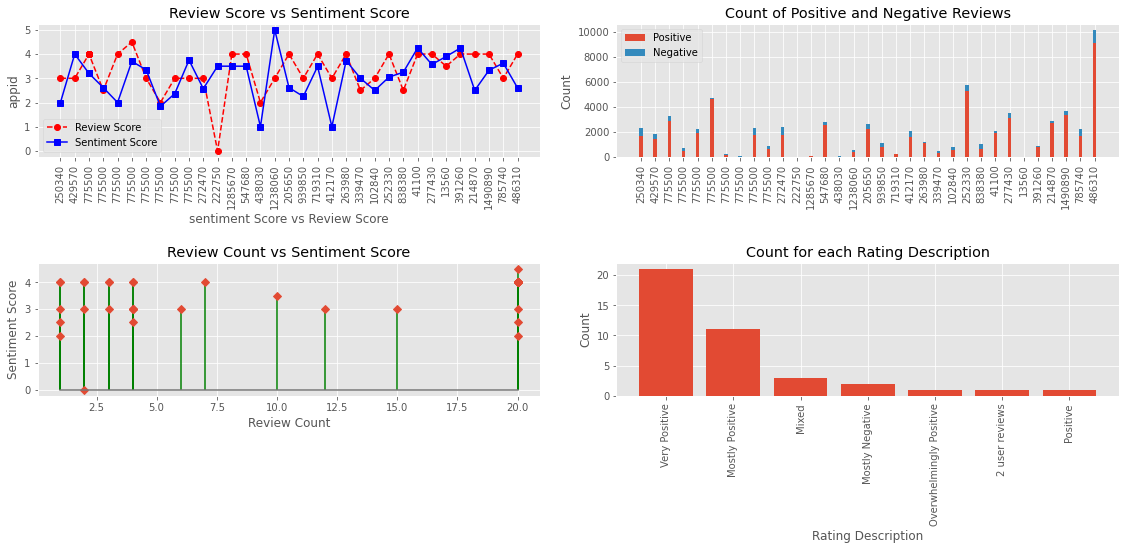

In [355]:
#Change this parameter to include more values to plot. Increasing the value will convolute the plot because of hig data volume
num = 40
fig , axes = plt.subplots(2,2, figsize = (16,8))

#Plot 1
axes[0,0].plot(df_Game_Stat[:num]['appid'], df_Game_Stat[:num]['review_score_normalized'],  'o--r')
axes[0,0].plot(df_Game_Stat[:num]['appid'], df_Game_Stat[:num]['bert_score'],'s-b')
axes[0,0].set_ylabel('appid')
axes[0,0].set_xticklabels(df_Game_Stat[:num]['appid'], rotation = 90)
axes[0,0].set_xlabel('sentiment Score vs Review Score')
axes[0,0].set_title('Review Score vs Sentiment Score')
axes[0,0].legend(['Review Score','Sentiment Score'])

#Plot 2 
label_format = '{:.0f}'
axes[0,1].bar(df_Game_Stat[:num]['appid'], df_Game_Stat[:num]['total_positive'], 0.25, label='Positive')
axes[0,1].bar(df_Game_Stat[:num]['appid'], df_Game_Stat[:num]['total_negative'], 0.25, bottom=df_Game_Stat[:num]['total_positive'],
       label='Negative')
axes[0,1].set_xticklabels(df_Game_Stat[:num]['appid'], rotation = 90)
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Count of Positive and Negative Reviews')
axes[0,1].legend()

#Plot 3
axes[1,0].stem(df_Game_Stat[:num]['num_reviews'], df_Game_Stat[:num]['review_score_normalized'], markerfmt='D', linefmt='green')
axes[1,0].set_xlabel('Review Count')
axes[1,0].set_ylabel('Sentiment Score')
axes[1,0].set_title('Review Count vs Sentiment Score')


#Plot 4
df = df_Game_Stat[:num]['review_score_desc'].value_counts().to_frame()
axes[1,1].bar(df.index, df['review_score_desc'])
axes[1,1].set_xticklabels(df.index, rotation = 90)
axes[1,1].set_xlabel('Rating Description')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Count for each Rating Description')


plt.tight_layout(pad = 2)

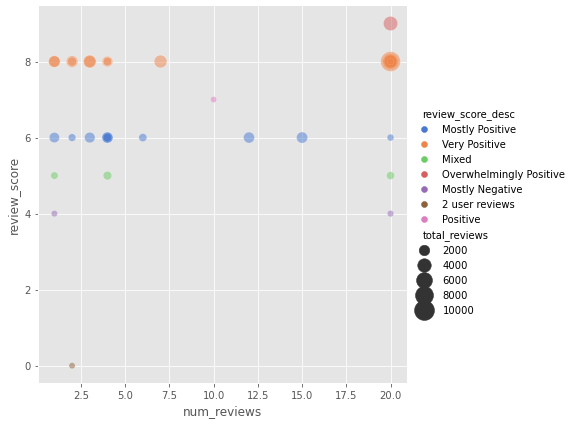

In [328]:
sns.relplot(x="num_reviews", y="review_score", hue="review_score_desc", size="total_reviews",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df_Game_Stat[:num])
plt.show()

In [361]:
def hat_graph(ax, xlabels, values, group_labels):
    
    def label_bars(heights, rects):
        """Attach a text label on top of each bar."""
        for height, rect in zip(heights, rects):
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 4),  # 4 points vertical offset.
                        textcoords='offset points',
                        ha='center', va='bottom')

    values = np.asarray(values)
    x = np.arange(values.shape[1])
    ax.set_xticks(x)
    spacing = 0.3  # spacing between hat groups
    width = (1 - spacing) / values.shape[0]
    heights0 = values[0]
    for i, (heights, group_label) in enumerate(zip(values, group_labels)):
        style = {'fill': False} if i == 0 else {'edgecolor': 'black'}
        rects = ax.bar(x - spacing/2 + i * width, heights - heights0,
                       width, bottom=heights0, label=group_label, **style)
        label_bars(heights, rects)


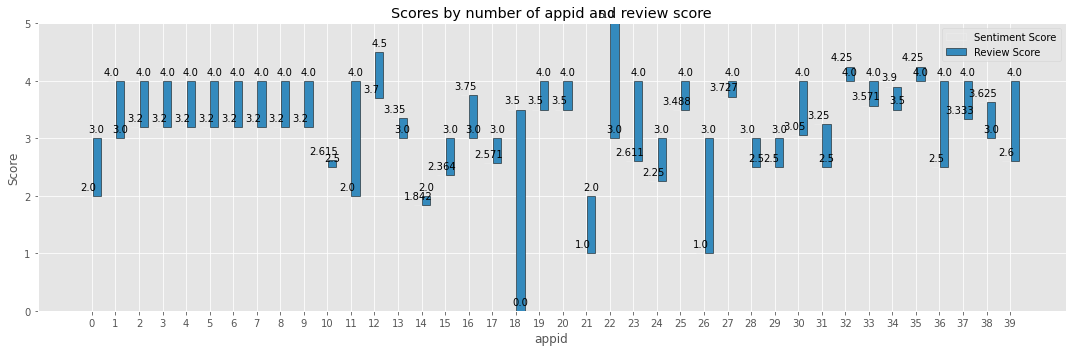

In [369]:
# initialise labels and a numpy array make sure you have   bert_score   review_score_normalized
# N labels of N number of values in the array
num = 40
plt.rcParams["figure.figsize"] = (15,5)
xlabels = df_Game_Stat[:num]['appid'].tolist()
bert_score = df_Game_Stat[:num]['bert_score'].tolist() 
review_score_normalized = df_Game_Stat[:num]['review_score_normalized'].tolist()

fig, ax = plt.subplots()
hat_graph(ax, xlabels, [bert_score, review_score_normalized], ['Sentiment Score', 'Review Score'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('appid')
ax.set_ylabel('Score')
ax.set_ylim(0, 5)
ax.set_title('Scores by number of appid and review score')
ax.legend()

fig.tight_layout()
plt.show()
